# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. Σύστημα συστάσεων βασισμένο στο περιεχόμενο - σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset στο dataframe `df_data_1`: 

In [152]:
from io import StringIO
import requests
import json
import pandas as pd

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_e83bb2ed70e300a3a681580fec6a7d42c6cd8eb2','domain': {'id': 'dd180082cfbb4aba93677ea2bbc9d7ff'},
            'password': 'y]333V2!.D=?Blh='}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

# Your data file was loaded into a StringIO object and you can process the data.
# Please read the documentation of pandas to learn more about your possibilities to load your data.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html
df_data_1 = pd.read_csv(get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed('DefaultProjectankynotpankygmailcom', 'movieDBe.csv'), sep='\t',  header=None, quoting=3)
df_data_2 = pd.read_csv(get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed('DefaultProjectankynotpankygmailcom', 'seedb.csv'),  header=None)

Το data frame `df_data_2` έχει 100 γραμμές και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. Η μεταβλητή `team_seed_number` έχει αλλάξει έτσι ώστε να έχει τον αριθμό της ομάδας μας.

In [153]:
!pip install numpy
import numpy as np
# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 62
my_index = df_data_2.iloc[team_seed_number,:].values
titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=100` θα γράψουμε `print corpus[100]`.

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="50%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [4]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer()
#vectorizer.fit(corpus)
#corpus_tf_idf = vectorizer.transform(corpus)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ δεν είναι βελτιστοποιημένη. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν δραματική επίδραση στην ποιότητα των συστάσεων και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη διαστατικότητα των δεδομένων. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους χρόνους εκπαίδευσης, ιδιαίτερα στη δεύτερη εφαρμογή.

Το σύστημα συστάσεων που θα παραδώσετε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίστε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται.

Σε markdown περιγράψτε πώς προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. Επίσης σε markdown δώστε 10 παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (4, 5 ή και παραπάνω) και σημειώστε συνοπτικά ποια είναι η θεματική που ενώνει τις ταινίες.

Δείτε [εδώ](https://pastebin.com/raw/ZEvg5t3z) ένα παράδειγμα εξόδου του βελτιστοποιημένου συστήματος συστάσεων για την ταίνία ["Q Planes"](https://en.wikipedia.org/wiki/Q_Planes) με την κλήση της συνάρτησης `content_recommender(529,3)`.

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
args = {
    "stop_words": "english",
    "lowercase": True,
    "norm": "l2",
    "use_idf": True,
    "smooth_idf": True,
    "sublinear_tf": True,
    "max_features": 800
}
vectorizer = TfidfVectorizer(**args)
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

Στις παραπάνω παραμέτρους του `TfidfVectorizer`, το `"stop_words": "english"` κάνει τον vectorizer να αφαιρέσει τις stop words από τα κείμενα, για να μην υπάρχουν πλέον κοινότυπες λέξεις που θα μπορούσαν να επηρεάσουν την ομοιότητα. To `"lowercase": True` κάνει όλους τους χαρακτήρες πεζούς, έτσι ώστε μια λέξη με κεφαλαίο πρώτο γράμμα να θεωρείται ίδια με μία άλλη με πεζό πρώτο γράμμα. Με το `"norm": "l2"` κανονικοποιούμε τα διανύσματα σύμφωνα με την ευκλείδια νόρμα, και με το `"use_idf": True` χρησιμοποιούνται τα `tfidf scores` έναντι των `tf scores`. Τέλος, χρησιμοποιείται η παράμετρος `"smooth_idf": True` ώστε να προστεθεί 1 στις συχνότητες των κειμένων και να αποφευχθεί η διαίρεση με το μηδέν, και το `"sublinear_tf": True` αντικαθιστά το tf με τον τύπο $1+\log(tf)$ ώστε να κανονικοποιηθεί λογαριθμικά.

In [129]:
from sklearn.externals import joblib
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

In [130]:
from sklearn.metrics.pairwise import cosine_similarity
class color:
   BOLD = '\033[1m'
   END = '\033[0m'
def content_recommender(target_movie,max_recommendations):
    cos_sim = cosine_similarity(corpus_tf_idf[target_movie],corpus_tf_idf)[0]
    sorted_cos_sim = [i[0] for i in sorted(enumerate(cos_sim), key=lambda x:x[1], reverse= True)]
    print (color.BOLD + "*** Target Movie " + str(target_movie) +" ***" + color.END)
    print (color.BOLD + "Title: " + color.END + titles[target_movie][0])
    print (color.BOLD + "Summary: " + color.END + corpus[target_movie])
    print (color.BOLD + "Genres: " + color.END + ', '.join(categories[target_movie]))
    print (color.BOLD + "*** " + str(max_recommendations) + " most related movies based on content ***" + color.END)
    c = 1
    for i in sorted_cos_sim[1:]:
        print (color.BOLD + "*** Recommended Movie No. " + str(c) + " ***" + color.END)
        print (color.BOLD + "Movie ID: " + color.END + str(i))
        print (color.BOLD + "Title: " + color.END + titles[i][0])
        print (color.BOLD + "Summary: " + color.END + corpus[i])
        print (color.BOLD + "Genres: " + color.END + ', '.join(categories[i]))
        if (c==max_recommendations):
            break
        c +=1

Παρακάτω σημειώνονται 10 παραδείγματα από τη συλλογή ταινιών που επιστρέφουν καλά αποτελέσματα, μαζί με τη θεματική που ενώνει τις ταινίες (`IDs: 0, 1256, 1712, 2200, 3072, 3155, 3178, 3408, 3757, 4079`)

In [131]:
content_recommender(0,4)

*** Target Movie 0 ***
Title: Gift Wrapped
Summary: Sylvester the cat awakes on Christmas morning to find a present for him. To his disappointment, it is merely a rubber mouse. He hears his hated rival Tweety singing Jingle Bells in his cage, which has been gift wrapped and addressed to Granny. Just before she enters the room, he switches the cage's tag so it's addressed "To Kitty" instead. Granny innocently gives the cage to Sylvester and opens the box with the rubber mouse. Believing there has been an innocent mix-up, she goes to give Sylvester the mouse and correct the mistake. Upon seeing a satisfied Sylvester hiccup Tweety's feathers, Granny realizes what has occurred and angrily forces Sylvester to regurgitate Tweety. After giving the wayward cat a scolding, Granny insists that Sylvester kiss Tweety under a sprig of mistletoe. Sylvester eats Tweety Bird again instead, and is once again scolded and forced to spit him out. Granny places Tweety's cage up high where Sylvester shouldn

Κοινή θεματική : Animation

In [133]:
content_recommender(1256,4)

*** Target Movie 1256 ***
Title: To Whom Does the World Belong?
Summary: Kuhle Wampe takes place in early-1930s Berlin. At the beginning of the film, an unemployed young man, brother of the protagonist Anni, throws himself from a window out of the despair that he had spent another day unsuccessfully seeking work. Shortly thereafter his family is evicted from their apartment. They move into a garden colony of sorts, with the name “Kuhle Wampe.” Anni, the family’s daughter and the only family member who still has a job, becomes pregnant and engaged to her boyfriend, Fritz, who that very evening describes that their marriage was demanded of him because of her pregnancy. Anni leaves Fritz and moves to her friend Gerda’s apartment. She later takes place in a worker’s sporting event where she meets Fritz again, who has recently lost his work, and they reunite. The climax of the film depicts their return home by train . Anni and Fritz as well as a handful of workers argue with middle-class an

Κοινή θεματική : Drama

In [135]:
content_recommender(1712,4)

*** Target Movie 1712 ***
Title: Moon in Taurus
Summary: Moon in Taurus is the story of a Swiss who, after absence of five years, returns to a small town in America where a love affair had come to an abrupt and, for him, unhappy end. Together with his film team, he tries to discover the reasons for the break-up of his relationship. His ex-girlfriend has since married and is in the throes of divorce. Parallel to this, he re-lives his own love relationship to this woman. Following a period of analytical observation, he becomes more and more involved with his own problems.
Genres: "Drama"
*** 4 most related movies based on content ***
*** Recommended Movie No. 1 ***
Movie ID: 4965
Title: Through the Eyes of a Killer
Summary: A woman has a brief affair with the contractor who is renovating her apartment and he refuses to accept the end of the relationship.
Genres: "Thriller",  "Psychological thriller"
*** Recommended Movie No. 2 ***
Movie ID: 2653
Title: Drifting
Summary: Robi  is a young 

Κοινή θεματική : Drama

In [140]:
content_recommender(2200,4)

*** Target Movie 2200 ***
Title: Green Legend Ran
Summary: Green Legend is set in a science fiction-style post-apocalyptic Earth, which has turned largely into a vast desert after an alien invasion, in which six of the "Rodo"  crashed onto Earth from space, somehow effecting massive climate change which has completely wiped out the oceans and rain. At the time, mankind was ruining the environment, making an apocalypse of some sort inevitable (similar to other environmentally-focused anime like [[Nausicaä of the Valley of the Wind . In this brutal new world, two polarized factions have arisen: the first faction, the "Rodoists" are a fanatical religious sect who worship the Rodo while practicing hydraulic despotism; all communities are clustered around one of the monoliths, as they are the only remaining sources of water and food - most of which is gathered quite close to the monoliths in what they call the "Holy Green". Travel between communities is infrequent, as at a certain distance 

Κοινή θεματική : Science Fiction

In [141]:
content_recommender(3072,4)

*** Target Movie 3072 ***
Title: Hell in Normandy
Summary: A squad of American paratrooper commandos led by Guy Madison is dropped into France prior to the invasion of Normandy. Once in enemy territory, the squad meets up with a German double agent  who helps them infiltrate a German flamethrower installation. The mission is to destroy the installation, which would threaten the Omaha Beach landing, right before the invasion begins.
Genres: "Action",  "Historical fiction",  "Adventure",  "War film"
*** 4 most related movies based on content ***
*** Recommended Movie No. 1 ***
Movie ID: 3546
Title: Breakthrough
Summary: Starting in late May 1944, during the German retreat on the Eastern Front, Captain Stransky  orders Sergeant Steiner  to blow up a railway tunnel to prevent Russian forces from using it. Steiner's platoon fails in its mission by coming up against a Russian tank. Steiner then takes a furlough to Paris just as the Allies launch their invasion of Normandy. Steiner's unit is 

Κοινή θεματική : War film

In [145]:
content_recommender(3155,4)

*** Target Movie 3155 ***
Title: Chukkallo Chandrudu
Summary: Arjun  is an NRI who lives with his grandfather  and grandmother Padmavathi . Padmavathi wants Arjun to get married. She also tells Arjun's grandfather but does not take it seriously. Suddenly one morning, Padmavathi dies in her sleep. Arjun's grandfather feels bad that he couldn't fulfill his wife's last wish: to get Arjun married. So he tries to convince Arjun for marriage. Arjun refuses and his grandfather leaves for India, where there are some people who will listen to him and give him respect. Arjun finds out that his grandfather is in India and flies from Germany to India to bring back his grandfather. His grandfather only agrees to come only if Arjun would marry. Arjun, along with the help of his friend Puppy ([[Sunil , close in on three girls: Shalini , Sravani  and Sandhya . Shalini is a tennis player, Sravani is a student who is pursuing MBBS, and Sandhya is women's activist. Incidentally, all three girls happen to

Κοινή θεματική : Comedy

In [146]:
content_recommender(3178,4)

*** Target Movie 3178 ***
Title: Disorganized Crime
Summary: The story begins in a small town in western Montana where New Jersey based bank robber Frank Salazar has been hiding out from the law after a series of bank robberies in Newark. Upon realizing that the local bank contains a large amount of cash, Salazar recruits four former accomplices to come to town and help him rob the bank. Among them are Nick Bartkowski, a nervous and possibly alcoholic safecracker; Max Green, an old school explosives expert with a heart condition; Ray Forgy, a young, wisecracking auto thief and getaway driver; and Carlos Barrios, a well-manicured lookout and weapons expert. Before they can arrive, however, two New Jersey detectives  catch up with Salazar, arrest him, and extradite him back to New Jersey. But Salazar soon escapes and becomes hopelessly lost in the Montana wilderness as he flees Denver and Lonigan's custody. Unaware of Salazar's arrest and escape, the four accomplices arrive and realize t

Κοινή θεματική : Crime Fiction, Action, Thriller

In [149]:
content_recommender(3408,4)

*** Target Movie 3408 ***
Title: Sock-A-Bye Baby
Summary: The Stooges awake in the middle of the night to a crying baby left on their doorstep. A letter from the despondent mother  states that baby Jimmie  has been "abandoned". The Stooges react by taking the little guy in, feeding him, and trying their best to act fatherly. Later, Larry finds a newspaper article stating a child kidnapping, and the Stooges believe that Jimmie is the child and the kidnappers left a phony note. When the mother and two motorcycle cops come to reclaim the baby, the Stooges evacuate their home quickly, with Jimmie in tow; unbeknownst to the stooges Jimmie crawled into the back seat of their car. The police on their motorcycles track them down and the baby is returned to the parents who, the father being one of the cops, reconcile. The Stooges, meanwhile, make a conspicuous escape by skittering away hidden in large haystacks.
Genres: "Short Film",  "Comedy",  "Black-and-white"
*** 4 most related movies based

Κοινή θεματική : Family Film, Drama, Comedy

In [150]:
content_recommender(3757,4)

*** Target Movie 3757 ***
Title: Prom Night IV: Deliver Us from Evil
Summary: At Hamilton High School's 1957 prom , party goers Lisa and Brad leave the festivities to have sex in Brad's car. Before the two can undress, they are distracted by a noise, revealed to be someone putting candles on the hood of the car. After spotting the candles, Lisa has her throat slashed by a metal crucifix wielded by psychotic religious fanatic Father Jonas who also stabs Brad in the chest, afterward disposing of the teens' bodies by blowing up Brad's car. After committing this double homicide, Father Jonas, revealed to have stigmata, is transported from St. Basil Seminary to the St. George Church by a group of fellow priests led by Father Jaeger, who refers to the rambling Father Jonas as an abomination and believes him possessed by dark forces. In 1991 at St. George Church young Father Colin is informed by the now elderly Father Jaeger that his trip to Africa for missionary work has been put off and tha

Κοινή θεματική : Horror, Thriller

In [151]:
content_recommender(4079,4)

*** Target Movie 4079 ***
Title: Operation Sawdust
Summary: Lumber mill workers Woody Woodpecker and Buzz Buzzard are friends when they are sawing trees, but when Wally Walrus  rings the dinner bell, they become bitter enemies. Woody and Buzz duke it out over food, with the woods being pecked to death in the process.
Genres: "Short Film",  "Family Film",  "Animation"
*** 4 most related movies based on content ***
*** Recommended Movie No. 1 ***
Movie ID: 2957
Title: The Sound And The Silence
Summary: The film begins with Bell's childhood in Scotland, where his is initially intrigued by sights and sounds.CM Archive The film then follows his days as an inventor in Brantford, Ontario, Boston, Massachusetts, and Baddeck, Nova Scotia. The film was shot in New Zealand and on location at Alexander Graham Bell's Beinn Bhreagh estate in Baddeck, Nova Scotia, Canada.
Genres: "Biographical film",  "Drama"
*** Recommended Movie No. 2 ***
Movie ID: 3629
Title: Tinker Bell: Secret of the Wings
Summa

Κοινή θεματική : Animation, Family Film

## &spades; Tip: persistence αντικειμένων με joblib.dump

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
from sklearn.externals import joblib  
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα. Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [112]:
from sklearn.externals import joblib
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl',compress=9)

['corpus_tf_idf.pkl']

In [113]:
!ls -lh

total 24M
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 5.8K Jan 10 04:11 auxiliary.py
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 6.3K Jan 10 04:12 auxiliary.pyc
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 2.0M Jan 16 11:22 corpus_tf_idf1.pkl
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 2.0M Jan 16 12:41 corpus_tf_idf.pkl
drwx------ 2 s08a-9082e10dd730b1-6f702ff6845a users 4.0K Dec 20 03:25 MNIST_data
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 2.3M Jan 16 11:58 som1.pkl
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 2.3M Jan 16 12:30 som.pkl
drwx------ 3 s08a-9082e10dd730b1-6f702ff6845a users 4.0K Nov  8 04:03 tmp


Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

# Εφαρμογή 2.  Σημασιολογική απεικόνιση της συλλογής ταινιών με χρήση SOM
<img src="http://visual-memory.co.uk/daniel/Documents/intgenre/Images/film-genres.jpg" width="35%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` ως επιπλέον στήλες (χαρακτηριστικά). Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

In [115]:
def build_final_set(doc_limit = 5000):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    return final_set

In [116]:
limit = 5000
final_set = build_final_set(limit)

Μπορείτε να εξετάστε αργότερα αν περαιτέρω προεπεξεργασία του `final_set` έχει επίδραση στην ποιότητα του χάρτη SOM και του clustering.

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Πρόκειται για μια σύγχρονη και βελτιστοποιημένη υλοποίηση των SOM, παραλληλοποιημένη για CPU και GPU. Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [154]:
# install somoclu
!pip install somoclu
# import somoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

In [118]:
som = somoclu.Somoclu(n_columns=20,n_rows=20) #don't run this cell if already loaded "som.pkl"
%time som.train(data=final_set,epochs=100)

CPU times: user 10min 55s, sys: 3.12 s, total: 10min 58s
Wall time: 1min 50s


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.

In [155]:
from sklearn.externals import joblib
som = joblib.load('som.pkl') #pre-trained SOM

In [156]:
bmus = som.get_bmus(som.get_surface_state())
u, indices = np.unique(bmus, return_index =True, axis=0)

In [157]:
print (u) 
print (indices)

[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]
 [ 1 16]
 [ 1 17]
 [ 1 18]
 [ 2  0]
 [ 2  1]
 [ 2  2]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 2 11]
 [ 2 12]
 [ 2 13]
 [ 2 14]
 [ 2 15]
 [ 2 16]
 [ 2 17]
 [ 2 18]
 [ 2 19]
 [ 3  0]
 [ 3  1]
 [ 3  2]
 [ 3  3]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 3  9]
 [ 3 11]
 [ 3 12]
 [ 3 13]
 [ 3 14]
 [ 3 15]
 [ 3 16]
 [ 3 17]
 [ 3 18]
 [ 3 19]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 4  6]
 [ 4  7]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 4 11]
 [ 4 12]
 [ 4 13]
 [ 4 14]
 [ 4 15]
 [ 4 16]
 [ 4 17]
 [ 4 18]
 [ 4 19]
 [ 5  0]
 [ 5  1]
 [ 5  2]
 [ 5  3]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 5  7]
 [ 5  8]
 [ 5  9]
 [ 5 10]
 [ 5 11]
 [ 5 12]
 [ 5 13]
 [ 5 14]
 [ 5 15]
 [ 5 16]
 [ 5 17]
 

## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [158]:
from sklearn.cluster import KMeans #WARNING: Don't run this cell if already loaded "som.pkl", otherwise the analysis below will be incorrect!
clusters = 25
som.cluster(algorithm=KMeans(n_clusters=clusters))

## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [120]:
from sklearn.externals import joblib
joblib.dump(som,'som.pkl',compress=9)

['som.pkl']

In [121]:
!ls -lh

total 25M
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 5.8K Jan 10 04:11 auxiliary.py
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 6.3K Jan 10 04:12 auxiliary.pyc
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 2.0M Jan 16 11:22 corpus_tf_idf1.pkl
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 2.0M Jan 16 12:41 corpus_tf_idf.pkl
drwx------ 2 s08a-9082e10dd730b1-6f702ff6845a users 4.0K Dec 20 03:25 MNIST_data
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 2.3M Jan 16 11:58 som1.pkl
-rw------- 1 s08a-9082e10dd730b1-6f702ff6845a users 2.3M Jan 16 12:44 som.pkl
drwx------ 3 s08a-9082e10dd730b1-6f702ff6845a users 4.0K Nov  8 04:03 tmp


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">


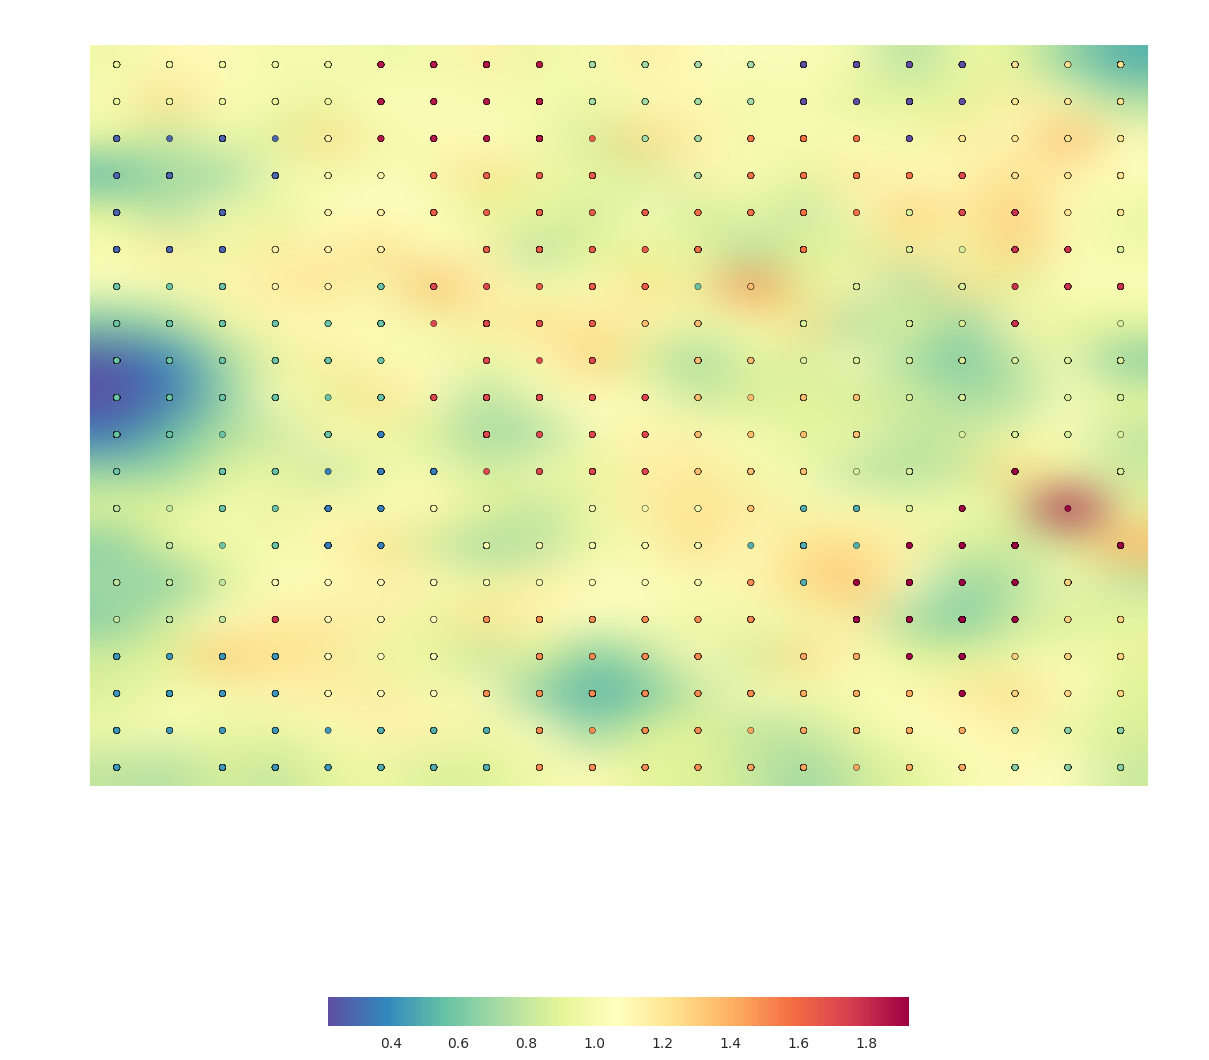



[[10 10 10 10 10 23 23 23 23  7  7  7  7  0  0  0  0 14 14 14]
 [10 10 10 10 10 23 23 23 23  7  7  7  7  0  0  0  0 14 14 14]
 [ 1  1  1  1 13 23 23 23 23 20  7  7 19 19 19  0 14 14 14 14]
 [ 1  1  1  1 13 13 20 20 20 20 20  7 19 19 19 19 21 14 14 14]
 [ 1  1  1 13 13 13 20 20 20 20 20 19 19 19 19  9 21 22 14 14]
 [ 1  1  1 13 13 13 13 20 20 20 20 19 19 19  9  9  9 22 22  9]
 [ 5  5  5 13 13  5 21 21 20 20 20  5 16  9  9  9  9 22 22 22]
 [ 5  5  5  5  5  5 21 21 21 20 16 16  9  9  9  9  9 22  9  9]
 [ 5  5  5  5  5  5 21 21 21 21 16 16 16  9  9  9  9  9  9  9]
 [ 5  5  5  5  5  5 21 21 21 21 21 16 16 16 16  9  9  9  9  9]
 [ 5  5  5  5  5  2 21 21 21 21 21 16 16 16 16  9  9  9  9  9]
 [ 5  5  5  5  2  2  2 21 21 21 21 16 16 16  9  9  9 24  9  9]
 [ 8  8  5  5  2  2 11 11 11 11 11 11 16  4  4  9 24 24 24  9]
 [ 8  8  5  5  2  2 11 11 11 11 11 11  4  4  4 24 24 24 24 24]
 [ 8  8  8 12 12 12 12 11 11 11 11 11 18  4 24 24 24 24 15 15]
 [ 8  8  8 22 12 12 12 18 18 18 18 18 18 18 24 24 24 

In [162]:
som.view_umatrix(figsize=(15, 15),colorbar=True,bestmatches=True)
print ('\n')
np.set_printoptions(linewidth=1000)
print (som.clusters)
print ('\n\nClusters sorted by increasing number of neurons:')
print ('Cluster index')
print ('Number of neurons')
c_bmus, c_counts = np.unique(som.clusters, return_counts=True)
ar = np.array([np.argsort(c_counts),np.asarray(sorted(c_counts))])
print (ar)

## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα νευρώνα (μη βελτιστοποιημένος χάρτης):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```


In [159]:
def print_categories_stats(movie_ids):
    total_categories = []
    for i in movie_ids:
        str1 = (categories[i][0].split(','))
        str1 = [x.strip(" ") for x in str1]
        total_categories.extend(str1)
    genres, g_counts = np.unique(total_categories, return_counts=True)
    sorted_genres = [x for _,x in sorted(zip(g_counts,genres),reverse=True)]
    print (list(zip(sorted_genres,sorted(g_counts,reverse=True))))

In [160]:
def print_cluster_neurons_movies_report(cluster):
    cluster_bmus = np.column_stack((np.where(som.clusters == cluster)[1],np.where(som.clusters == cluster)[0]))
    neuron_index = []
    for i in range(0,cluster_bmus.shape[0]):
        for j in range(0,u.shape[0]):
            if (u[j].tolist() == cluster_bmus[i].tolist()):
                for k in range(0,bmus.shape[0]):
                    if (bmus[k].tolist() == cluster_bmus[i].tolist()):
                        neuron_index.append(k)
    return neuron_index

In [161]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'
np.set_printoptions(linewidth=1000)
print (som.clusters)
print ("\n")
for i in range(0,clusters):
    print (color.BOLD+"Overall Cluster "+ str(i) +" Genres stats:\n"+ color.END)
    print_categories_stats(print_cluster_neurons_movies_report(i))
    print("\n")

[[10 10 10 10 10 23 23 23 23  7  7  7  7  0  0  0  0 14 14 14]
 [10 10 10 10 10 23 23 23 23  7  7  7  7  0  0  0  0 14 14 14]
 [ 1  1  1  1 13 23 23 23 23 20  7  7 19 19 19  0 14 14 14 14]
 [ 1  1  1  1 13 13 20 20 20 20 20  7 19 19 19 19 21 14 14 14]
 [ 1  1  1 13 13 13 20 20 20 20 20 19 19 19 19  9 21 22 14 14]
 [ 1  1  1 13 13 13 13 20 20 20 20 19 19 19  9  9  9 22 22  9]
 [ 5  5  5 13 13  5 21 21 20 20 20  5 16  9  9  9  9 22 22 22]
 [ 5  5  5  5  5  5 21 21 21 20 16 16  9  9  9  9  9 22  9  9]
 [ 5  5  5  5  5  5 21 21 21 21 16 16 16  9  9  9  9  9  9  9]
 [ 5  5  5  5  5  5 21 21 21 21 21 16 16 16 16  9  9  9  9  9]
 [ 5  5  5  5  5  2 21 21 21 21 21 16 16 16 16  9  9  9  9  9]
 [ 5  5  5  5  2  2  2 21 21 21 21 16 16 16  9  9  9 24  9  9]
 [ 8  8  5  5  2  2 11 11 11 11 11 11 16  4  4  9 24 24 24  9]
 [ 8  8  5  5  2  2 11 11 11 11 11 11  4  4  4 24 24 24 24 24]
 [ 8  8  8 12 12 12 12 11 11 11 11 11 18  4 24 24 24 24 15 15]
 [ 8  8  8 22 12 12 12 18 18 18 18 18 18 18 24 24 24 24

## Σχολιασμός Αποτελεσμάτων
1. Το cluster που περιέχει τα δεδομένα (ταινίες) που έχουν την μεγαλύτερη πυκνότητα πιθανότητας στον χώρο βρίσκονταιcluster 9. Αυτή η κατηγορία ταινιών είναι η "Animation" με 207 ταινίες. Αυτός ο αριθμός είναι πολύ μεγάλος και όπως είναι λογικό οδηγεί στο γεγονός το cluster 9 να απεικονίζεται με 40 νευρώνες στο χώρο μειωμένης διαστατικότητας, αριθμός που θεωρείται αρκετά μεγάλος. Μερικά παραδείγματα κατηγοριών ταινιών με ελάχιστες εμφανίσεις είναι οι "Auto Racing", "Albino bias", "Period piece" κλπ. που εμφανίζονται κυρίως σε clusters με πολύ μικρό αριθμό αντίστοιχων νευρώνων (πχ clusters 6, 22).
2. Είδη ταινιών που δεν έχουν καμία συγγένεια μεταξύ τους είναι για παράδειγμα οι "Thriller" και οι "Comedy" (αντίστοιχα clusters 0 και 3). Αυτά τα 2 clusters, όπως φαίνεται και στον πίνακα είναι πολύ απομακρυσμένα μεταξύ τους (πάνω δεξιά και κάτω αριστερά αντίστοιχα), γεγονός που μας δείχνει ότι τα αποτελέσματά μας είναι όπως ακριβώς αναμέναμε.
3. Δύο είδη ταινιών που βρίσκονται πού κοντά μεταξύ τους σε θεματολογία είναι οι "Horror" και "Thriller" που ανήκουν στα clusters 16 και 20. Αυτοί οι δύο αριθμοί βρίσκονται σχεδόν "κολλητά" στον χάρτη (στο κέντρο του) που έχουμε εξάγει πράγμα που είναι απολύτως φυσιολογικό και το περιμέναμε.

Το cluster 24, που έχει αρκετούς αντίστοιχους νευρώνες (20), είναι ένα πολύ καλό παράδειγμα μεγάλου cluster που δεν έχει σαφή χαρακτηριστικά (περιέχει ήδη ταινιών όπως "Documentary", "Animation", "Drama", "Comedy", "Sports" κλπ.) ενώ ένα αντίστοιχα μικρό cluster (το μικρότερο από άποψη νευρώνων) είναι το 6 (περιέχει "Drama", "Science Fiction", "Adventure", "Western" κλπ.).

Τα clusters 9 και 16 βρίσκονται δίπλα - δίπλα στον χάρτη αλλά περιέχουν τελείως διαφορετική θεματολογία. Στο 9 βρίσκονται κυρίως "Animation" ταινίες ενώ στο 16 ταινίες του τύπου "Horror" και "Thriller". Αυτό το φαινόμενο οφείλεται στο γεγονός ότι το clustering γίνεται μέσω των λέξεων που υπάρχουν στις περιγραφές των ταινιών. Πιο συγκεκριμένα, δύο λέξεις που μπορούν να υπάρχουν και σε ταινίες της κατηγορίας "Horror" ή "Thriller", αλλά και σε ταινίες τύπου "Animation", επιδρούν με τέτοιο τρόπο στο clustering, έτσι ώστε να δημιουργείται η εντύπωση ότι αυτά τα είδη ταινιών είναι συγγενικά μεταξύ τους, κάτι το οποίο προφανώς δεν ισχύει. 

Τα clusters 2, 4, 11, 16, 20 και 22 είναι τα καλύτερα (Discovery Value Clusters) σε θέμα ομαδοποίησης ειδών ταινιών, δηλαδή τα είδη ταινιών που περιέχουν βρίσκονται πολύ "κοντά" μεταξύ τους σε ότι αφορά τη θεματολογία.
Πιο συγκεκριμένα, το 2ο cluster περιέχει κυρίως ταινίες τύπου "Comedy Film", "Parody" και "Satire", 3 μεγάλες κατηγορίες που όντως βρίσκονται πολύ κοντά μεταξύ τους όπως γνωρίζουμε από δικές μας εμπειρίες με ταινίες. Το ίδιο ακριβώς συμβαίνει και στα clusters 11, 16 και 20. Το πιο βασικό είδος ταινιών που περιέχουν αυτά τα 3 clusters είναι το "Thriller". Φυσικά, όπως είναι λογικό, κοντά σε αυτή την κατηγορία υπάρχουν και ταινίες "Horror", "Suspense" ή "Mystery" κ.ά που θεματικά είναι πολύ κοντά στις 3 κύριες κατηγορίες που είδαμε προηγουμένως. Το cluster 22, αντίθετα με αυτά που είδαμε μέχρι στιγμής, περιέχει κυρίως ταινίες του είδους "Adventure" ή "Science Fiction" και "Action". Τέλος, το cluster 4 περιέχει ταινίες τύπου "Drama", "Romance Film" και "Romantic comedy". Όπως, λοιπόν, θα θέλαμε και τα 2 τελευταία αυτα clusters (22 και 4) περιέχουν το καθένα είδη ταινιών που είναι συγγενικά, γεγονός που μας αρέσει ιδιαίτερα γιατί μας οδηγεί στο συμπέρασμα πως έχουμε πραγματοποιήσει ένα αρκετά ικανοποιητικό clustering. Ολοκληρώνοντας, είναι καλό να αναφέρουμε και πάλι πως σε αυτά τα 6 clusters που αναλύσαμε, ο αριθμός των νευρώνων που τα απεικονίζουν στο χώρο μειωμένης διαστατικότητας είναι σχετικά μεγάλος (>8), πράγμα που επιβεβαιώνει όσα είπαμε προηγουμένως.

# Στοιχεία Ομάδας

Λεούσης Σάββας Α.M.: 03114945 

Ζαραβίνος Γεώργιος Α.M.: 03114158